In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers.legacy import Optimizer
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

! pip install -q scikeras
from scikeras.wrappers import KerasRegressor

import pickle

In [ ]:
data = pd.read_csv('Indian ATM preprocessed.csv')
data

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-0.420395,-0.304479,0.120964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,503400.0
1,-1.296688,-1.199232,-1.463074,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,123800.0
2,-0.858541,-1.074961,-0.911767,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,287700.0
3,2.628376,2.255508,1.078115,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,945300.0
4,2.409303,-0.031083,-0.276599,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,767900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12670,-0.402139,0.093189,0.346663,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,2.0,8.0,498300.0
12671,-0.055272,-0.602730,-0.102665,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,2.0,8.0,544800.0
12672,0.547179,-0.329333,-0.135278,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,2.0,8.0,608600.0
12673,0.072520,0.267168,1.646505,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,2.0,8.0,902500.0


In [ ]:
l1 = int(len(data) * 0.65)
D1, D2 = data.loc[:l1, :], data.loc[l1:, :]

l2 = l1 + int(len(D2) * 0.7)

D2_train, D2_val = D2.loc[l1:l2, :], D2.loc[l2:, :]

In [ ]:
num_features = 32

D1_features = D1.iloc[:, :num_features]
D2_features = D2.iloc[:, :num_features]

D1_targets = D1.iloc[:, num_features:]
D2_targets = D2.iloc[:, num_features:]

D2_train_features = D2_train.iloc[:, :num_features]
D2_train_targets = D2_train.iloc[:, num_features:]

D2_val_features = D2_val.iloc[:, :num_features]
D2_val_targets = D2_val.iloc[:, num_features:]

In [ ]:
# Normalize targets
target_mean = D1_targets.mean()
target_std = D1_targets.std()

D1_targets_normalized = (D1_targets - target_mean) / target_std
D2_targets_normalized = (D2_targets - target_mean) / target_std

D2_train_targets_normalized = (D2_train_targets - target_mean) / target_std
D2_val_targets_normalized = (D2_val_targets - target_mean) / target_std

In [ ]:

from tensorflow.keras.regularizers import l2

def get_NN_y(D1_features, D1_targets, D2_features, D2_targets):

    # Define NN_y model
    NN_y = Sequential([
        Dense(64, activation='relu', input_shape=(D1_features.shape[1],)),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(1, activation='linear')
    ])

    opt = keras.optimizers.Adam(learning_rate=0.001, decay=0.01)

    # Compile model
    NN_y.compile(optimizer=opt, loss='mse', metrics=['mae'])

    # Train NN_y
    history_y = NN_y.fit(
        D1_features, D1_targets,
        validation_data=(D2_features, D2_targets),
        epochs=500,
        batch_size=64,
        verbose=1,
    )

    return NN_y, history_y


In [ ]:
NN_y, history_y = get_NN_y(D1_features, D1_targets_normalized, D2_features, D2_targets_normalized)

Epoch 1/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1.1675 - mae: 0.8202 - val_loss: 0.3730 - val_mae: 0.4963
Epoch 2/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4256 - mae: 0.4974 - val_loss: 0.1549 - val_mae: 0.3168
Epoch 3/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2590 - mae: 0.3932 - val_loss: 0.0931 - val_mae: 0.2406
Epoch 4/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1838 - mae: 0.3292 - val_loss: 0.0670 - val_mae: 0.1975
Epoch 5/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1229 - mae: 0.2712 - val_loss: 0.0593 - val_mae: 0.1884
Epoch 6/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1060 - mae: 0.2552 - val_loss: 0.0662 - val_mae: 0.1994
Epoch 7/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0902 - mae: 0.2335 - val_loss: 0.0511 - val_mae: 0.1733
Epoch 8/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0806 - mae: 0.2214 - val_loss: 0.0566 - val_mae: 0.1867
Epoch 9/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5m

In [ ]:

NN_y.save('NN_y_norm.keras')
NN_y.save('NN_y_norm.h5')

with open('NN_y_norm', 'wb') as file:

    pickle.dump(NN_y, file)

NN_y.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,285 (223.77 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 38,020 (148.52 KB)

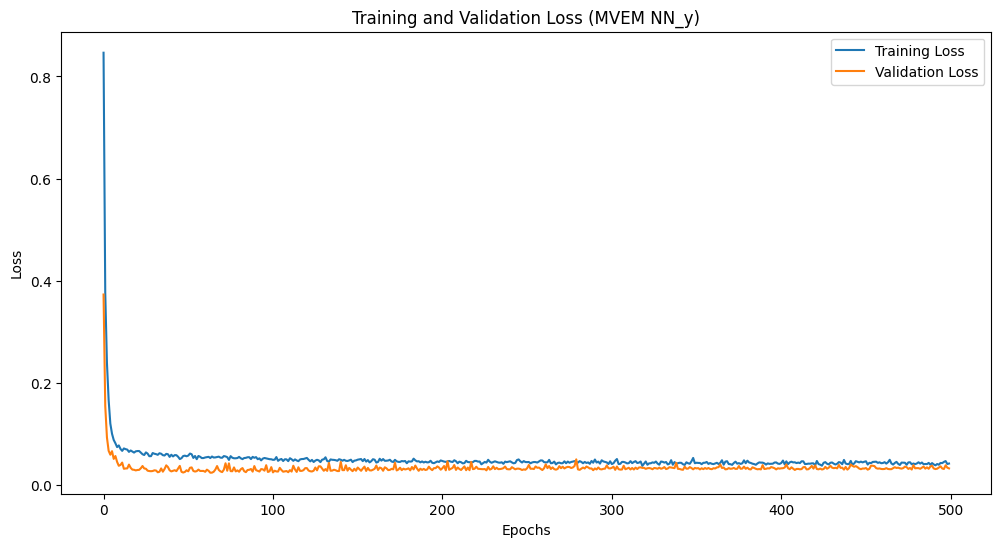

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history_y.history['loss'], label='Training Loss')
plt.plot(history_y.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (MVEM NN_y)')
plt.show()

In [ ]:

# Compute Z-scores for the target values
z_scores = np.abs((D2_targets - D2_targets.mean()) / D2_targets.std())

# Define a threshold to identify outliers
outlier_threshold = 3
weights = np.where(z_scores > outlier_threshold, 0.5, 1.0)  # Assign lower weight to outliers



def mve_loss(y_true_combined, y_pred):
    true_targets = y_true_combined[:, 0]
    mean_predictions = y_true_combined[:, 1]

    variance = tf.exp(y_pred) + 1e-10  # Ensure positive variance

    log_variance = tf.math.log(variance)
    squared_error = (true_targets - mean_predictions) ** 2 / variance

    # Regularization term to penalize large variances
    lambda_reg = 1e-3
    regularization = lambda_reg * variance

    loss = (log_variance + squared_error + regularization)

    return tf.reduce_mean(loss)



In [ ]:
from tensorflow.keras.regularizers import l2

def get_NN_sigma(D2_train_features, D2_train_targets_combined, D2_val_features, D2_val_targets_normalized):

    # Define NN_sigma model
    NN_sigma = Sequential([

        Dense(64, activation='relu', input_shape=(num_features,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='exponential',)  # Exponential to ensure positive variance
    ])


    # Compile NN_sigma with the updated loss function

    optimizer = Adam(learning_rate=0.0002,)
    NN_sigma.compile(optimizer=optimizer, loss=mve_loss, metrics=['mae'])


    # Train NN_sigma
    history_sigma = NN_sigma.fit(
        D2_train_features,
        D2_train_targets_combined,  # Combined targets (true + mean_predictions)
        validation_data=(D2_val_features, np.column_stack((D2_val_targets_normalized, NN_y.predict(D2_val_features)))),
        epochs=500,
        batch_size=64,
        verbose=1,
      )

    return NN_sigma, history_sigma



In [ ]:
# Precompute predictions from NN_y
mean_predictions = NN_y.predict(D2_train_features)

# Concatenate true targets and precomputed mean predictions
D2_train_targets_combined = np.column_stack((D2_train_targets_normalized, mean_predictions))


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
NN_sigma, history_sigma = get_NN_sigma(D2_train_features, D2_train_targets_combined, D2_val_features, D2_val_targets_normalized)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9410 - mae: 1.5064 - val_loss: 0.2368 - val_mae: 0.8930
Epoch 2/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1799 - mae: 0.9569 - val_loss: 0.0837 - val_mae: 0.7806
Epoch 3/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0702 - mae: 0.9232 - val_loss: 0.0487 - val_mae: 0.7580
Epoch 4/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0449 - mae: 0.9242 - val_loss: 0.0399 - val_mae: 0.7527
Epoch 5/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0400 - mae: 0.9021 - val_loss: 0.0363 - val_mae: 0.7504
Epoch 6/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0348 - mae: 0.8783 - val_loss: 0.0348 - val_mae: 0.7495
Epoch 7/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0344 - mae: 0.8902 - val_loss: 0.0342 - val_mae: 0.7492
Epoch 8/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0339 - mae: 0.8826 - val_loss: 0.0338 - val_mae: 0.7490
Epoch 9/500
49/49 ━━━━━━━

In [ ]:

NN_sigma.save('NN_sigma_norm.keras')
NN_sigma.save('NN_sigma_norm.h5')

with open('NN_sigma_norm', 'wb') as file:

    pickle.dump(NN_sigma, file)

NN_sigma.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,261 (219.77 KB)

 Trainable params: 18,753 (73.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 37,508 (146.52 KB)

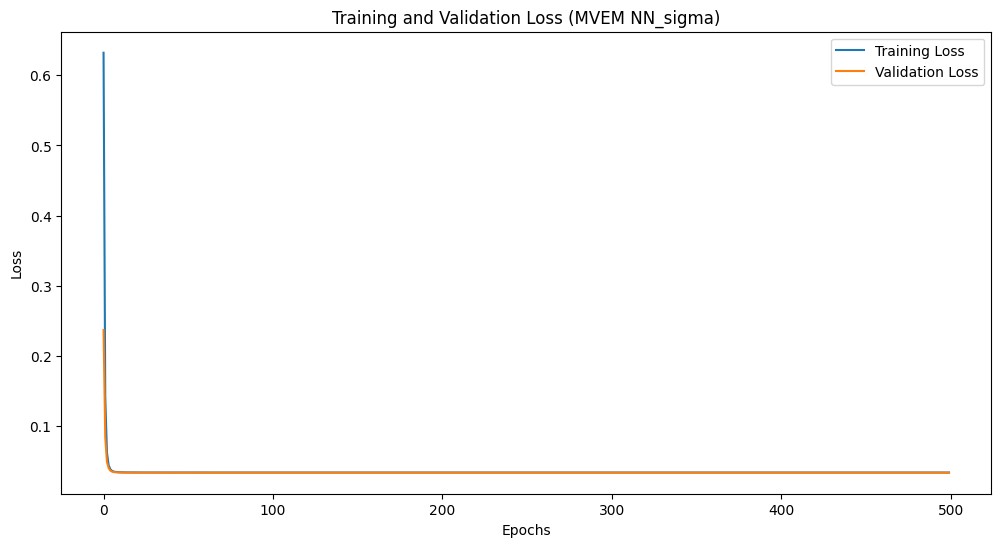

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history_sigma.history['loss'], label='Training Loss')
plt.plot(history_sigma.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (MVEM NN_sigma)')
plt.show()

In [ ]:
# Predict the mean (from NN_y) and variance (from NN_sigma)
mean_predictions = NN_y.predict(D2_features)
variance_predictions = np.exp(NN_sigma.predict(D2_features))  # Apply exp to get positive variance

# Denormalize mean predictions
mean_predictions_denormalized = mean_predictions * target_std[0] + target_mean[0]

# Denormalize variance predictions
variance_predictions_denormalized = variance_predictions * (target_std[0] ** 2)  # Variance scales with the square of std


139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
import scipy.stats

# Set confidence level
confidence_level = 0.30
z_score = scipy.stats.norm.ppf((1 + confidence_level) / 2)

# Compute upper and lower bounds of the prediction intervals
lower_bound = mean_predictions_denormalized - z_score * np.sqrt(variance_predictions_denormalized)
upper_bound = mean_predictions_denormalized + z_score * np.sqrt(variance_predictions_denormalized)


# Check if true targets fall within the PIs
within_pi = (D2_targets >= lower_bound) & (D2_targets <= upper_bound)

# Calculate PICP
PICP = np.mean(within_pi)

pi_width = upper_bound - lower_bound

# Calculate MPIW
MPIW = np.mean(pi_width)


In [ ]:
print("\nPrediction Interval Coverage Probability (PICP):", PICP)
print("\nMean Prediction Interval Width (MPIW):", MPIW)


Prediction Interval Coverage Probability (PICP): 0.9574036511156186

Mean Prediction Interval Width (MPIW): 184539.33


In [ ]:
def plot(y_train, y_test, lower_bound, upper_bound):

    test_len = 100
    train_len = len(y_train) - 300
    X_axis = range(train_len + test_len)

    plt.figure(figsize=(25,10))

    plt.fill_between(
        range(300, 400),
        lower_bound.flatten()[:test_len],
        upper_bound.flatten()[:test_len],
        color="orange",
        alpha=0.9,
        label="95% Prediction Interval",
        zorder=1
    )

    plt.plot(range(300), y_train[train_len:], color='blue', zorder=2, label = 'Original Value')
    plt.plot(range(300, 400), y_test[:test_len], color='blue', zorder=2)


    plt.legend()
    plt.xlabel("Timeline")
    plt.ylabel("Transaction Amount")
    plt.title(f"Prediction Intervals using MVEM Loss")
    plt.show()


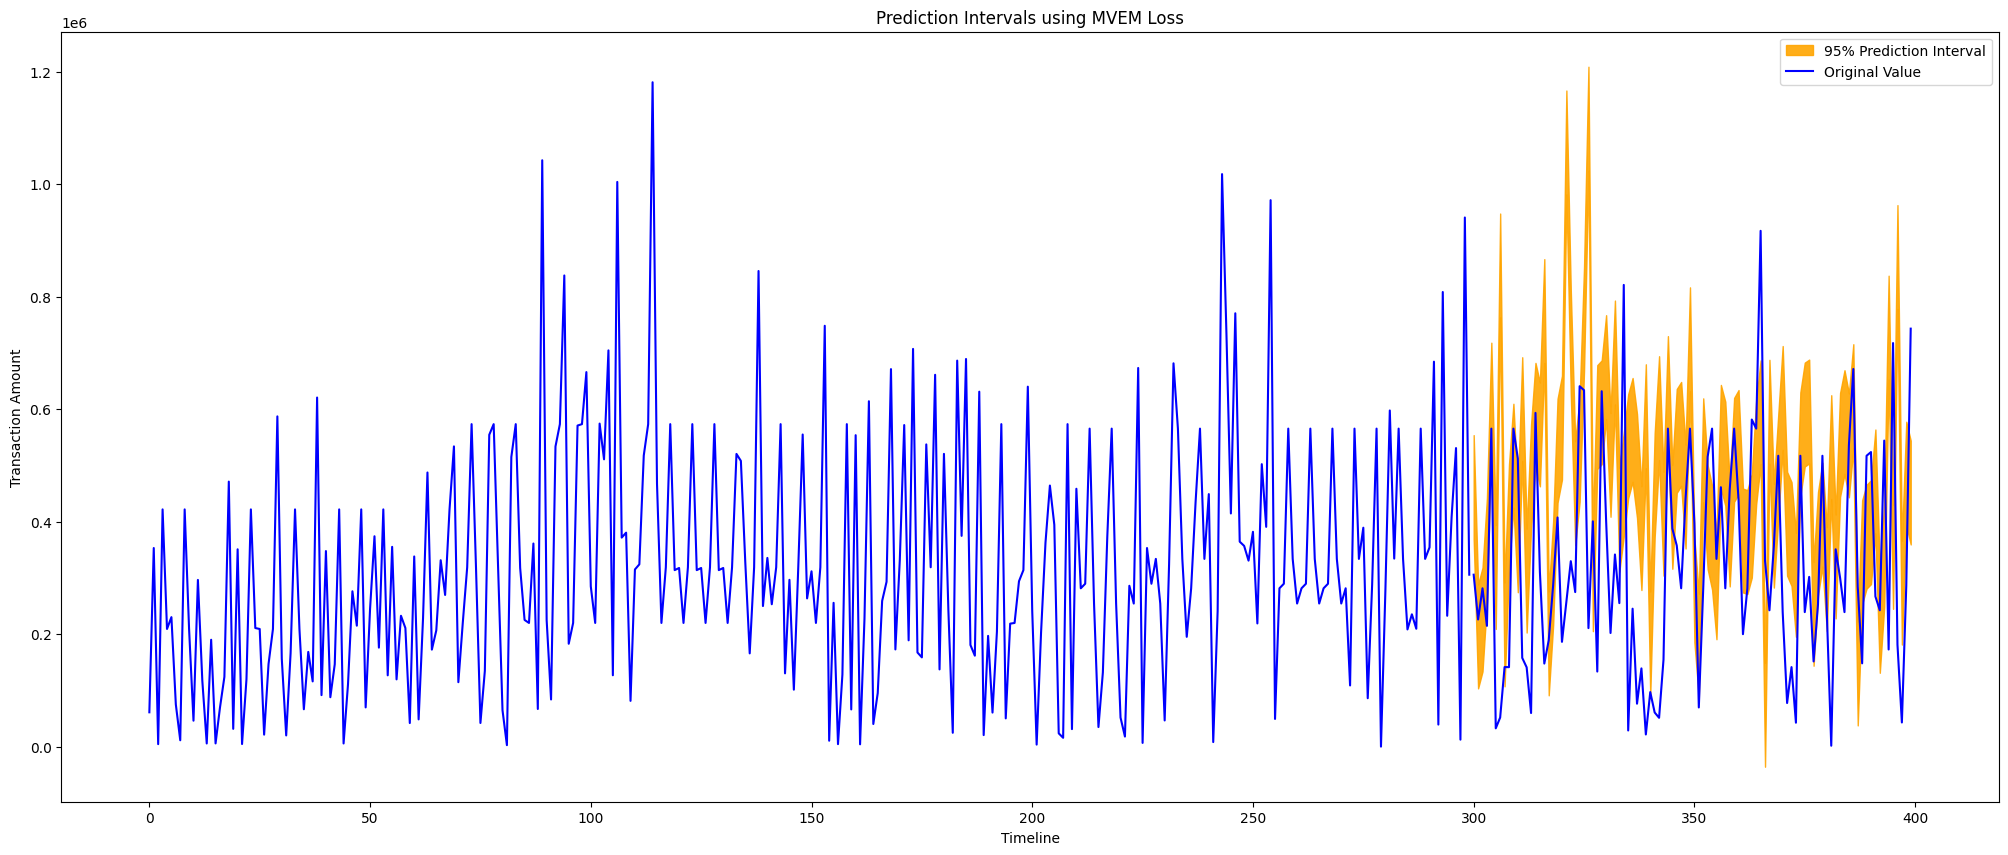

In [ ]:
plot(D2_train_targets, D2_val_targets, lower_bound, upper_bound)

In [ ]:


result = pd.DataFrame({'Original': np.array(D2_targets).flatten(), 'Predicted': mean_predictions_denormalized.flatten(),
                        'Lower Bound': lower_bound.flatten(), 'Upper Bound': upper_bound.flatten(),
                      })

outcome = (result['Original'] > result['Lower Bound']) & (result['Original'] < result['Upper Bound'])


result['Outcome'] = outcome.apply(lambda x: 0 if x == True else 1)

result.to_csv(f'Results_MVEM.csv', index=False)
